In [1]:
from Code_Testing_Scripts.custom_loss_fn_tester import test_custom_loss
import numpy as np
import torch




In [2]:
class HistogramLoss(torch.nn.Module):
    def __init__(self, num_bins=256):
        super(HistogramLoss, self).__init__()
        self.num_bins = num_bins

    def histogram_intersection(hist1, hist2):
        min_hist = torch.min(hist1, hist2)
        return torch.sum(min_hist)

    def forward(self, input_image, target_image):
        hist_input = torch.histc(input_image, bins=self.num_bins, min=0, max=255)
        hist_target = torch.histc(target_image, bins=self.num_bins, min=0, max=255)

        hist_input = hist_input / hist_input.sum()
        hist_target = hist_target / hist_target.sum()

        loss = 1 - self.histogram_intersection(hist_input, hist_target)

        return loss

In [3]:
class ffACBLoss(torch.nn.Module):
    def __init__(self, zero_weighting=1, nonzero_weighting=1, fullframe_weighting=1):
        """
        Initializes the ACB-MSE Loss Function class with weighting coefficients.

        Args:
        - zero_weighting: a scalar weighting coefficient for the MSE loss of zero pixels
        - nonzero_weighting: a scalar weighting coefficient for the MSE loss of non-zero pixels
        """
        super().__init__()   
        self.zero_weighting = zero_weighting
        self.nonzero_weighting = nonzero_weighting
        self.fullframe_weighting = fullframe_weighting
        self.mse_loss = torch.nn.MSELoss(reduction='mean')

    def forward(self, reconstructed_image, target_image):
        """
        Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
        The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
        pixels is weighted by nonzero_weighting.

        Args:
        - target_image: a tensor of shape (B, C, H, W) containing the target image
        - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image

        Returns:
        - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
        """
        zero_mask = (target_image == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)
        full_frame_loss = self.mse_loss(reconstructed_image, target_image)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss) + (self.fullframe_weighting * full_frame_loss)

        return weighted_mse_loss

class True3DLoss(torch.nn.Module):
    def __init__(self, zero_weighting=1, nonzero_weighting=1, timesteps=100):
        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """
        super().__init__()   
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
        self.timesteps = timesteps
        self.zero_weighting = zero_weighting
        self.nonzero_weighting = nonzero_weighting

    def ACB_MSE_Loss (self, reconstructed, target):
        reconstructed_image = reconstructed.clone()
        target_image = target.clone()
        """
        Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
        The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
        pixels is weighted by nonzero_weighting.

        Args:
        - target_image: a tensor of shape (B, C, H, W) containing the target image
        - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image

        Returns:
        - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
        """
        zero_mask = (target_image == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss)

        return weighted_mse_loss

    def expand_data_to_new_dimPREFERED(self, input_tensor):
        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """

        # QUANITSE VALUES IN THE TENSOR TO steps of (1/timesteps) then multiply by timesteps to arrive at integers (this simplifies to juyt * timestep then round)
        #quantised_tensor = torch.round(input_tensor * self.timesteps) # / timesteps

        # Determine the number of classes (third dimension size)
        num_classes = self.timesteps #int(input_tensor.max()) + 1

        # Convert the input tensor to indices
        indices = input_tensor.long()

        # Create a mask for non-zero values
        #non_zero_mask = input_tensor != 0

        # Create one-hot encoded tensor
        one_hot_encoded = torch.nn.functional.one_hot(indices, num_classes=num_classes).float()

        # Apply the mask to exclude zero values
        #one_hot_encoded = one_hot_encoded * non_zero_mask.unsqueeze(-1)

        # Permute dimensions to move the new dimension to the front
        #one_hot_encoded = one_hot_encoded.permute(0, 1, 4, 2, 3)
        
        return one_hot_encoded

    def expand_data_to_new_dim(self, input_tensor):
        input_tensor = (input_tensor * self.timesteps) - 1

        input_tensor = torch.where(input_tensor < 0, torch.tensor(0.0), input_tensor)   # could try input_tensor + 1.0 instead of  torch.tensor(0.0)

        # Assuming you have 'indices' and 'num_classes' defined
        num_classes =  self.timesteps
        indices = input_tensor.long()

        # Reshape the indices tensor for compatibility with scatter_
        reshaped_indices = indices.view(indices.size(0), indices.size(1), -1)

        # Create a tensor of zeros with the same shape as 'reshaped_indices'
        one_hot_encoded = torch.zeros(reshaped_indices.size(0), reshaped_indices.size(1), num_classes, reshaped_indices.size(2), requires_grad=True)
        
        # Use scatter to fill the one-hot encoded tensor (without in-place operation)
        one_hot_encoded = one_hot_encoded.scatter(2, reshaped_indices.unsqueeze(2), 1)

        # Convert the tensor to float
        one_hot_encoded = one_hot_encoded.float()

        return one_hot_encoded

    def forward(self, reconstructed_image, target_image):
        reconstructed_3D_view = self.expand_data_to_new_dim(reconstructed_image)
        target_3D_view = self.expand_data_to_new_dim(target_image)
        true3d_loss = self.ACB_MSE_Loss(reconstructed_3D_view, target_3D_view)
        return true3d_loss

c:\Users\Ada\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Time taken to compute loss:
0.1061292999656871
Gradient computation successful!
Time taken to compute loss:
0.12495820003096014
Gradient computation successful!
Time taken to compute loss:
0.08481819997541606
Gradient computation successful!
Time taken to compute loss:
0.08465780003461987
Gradient computation successful!
Time taken to compute loss:
0.4241234000073746
Gradient computation successful!
Time taken to compute loss:
0.4225049000233412
Gradient computation successful!


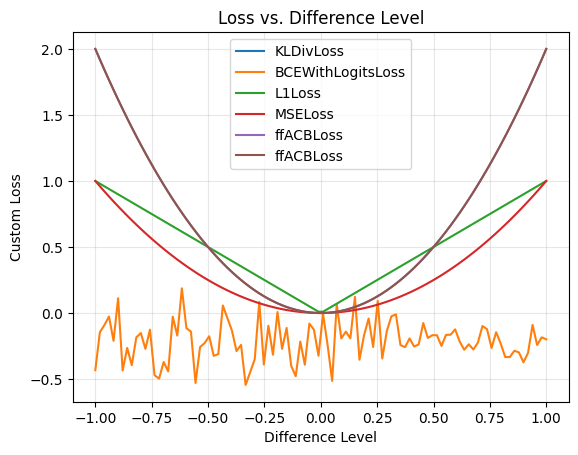

In [4]:
test_custom_loss( torch.nn.KLDivLoss(), torch.nn.BCEWithLogitsLoss(), torch.nn.L1Loss(), torch.nn.MSELoss(), ffACBLoss(1.0, 1.0, 1.0), ffACBLoss(0.5, 0.5, 1.5))

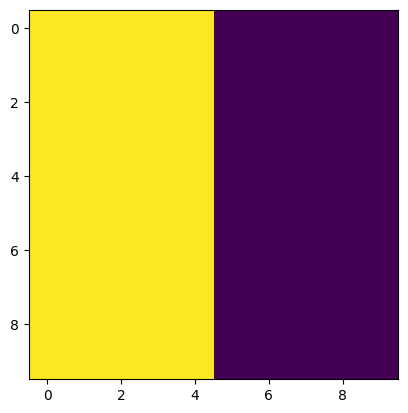

In [5]:
import matplotlib.pyplot as plt

dummy_img1 = torch.zeros(1,1,10,10)
#set 50% of pixels to hits
dummy_img1[:,:,:,0:5] = 1.0
plt.imshow(dummy_img1[0,0])